In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')

In [6]:
train_df.loc[train_df.Transported==True].shape[0]/train_df.shape[0] #没有样本不均衡的问题

0.5036236051995858

In [7]:
full_df = train_df.append(test_df, ignore_index=True)

In [8]:
full_df['HomePlanet'] = full_df['HomePlanet'].fillna('Earth')
full_df['CryoSleep'] = full_df['CryoSleep'].fillna(True)

In [9]:
full_df.loc[full_df.Cabin.notna(), 'Cabin_beck'] = \
         full_df.loc[full_df.Cabin.notna(), 'Cabin'].astype(str).map(lambda x: x.split('/')[0])
full_df.loc[full_df.Cabin.notna(), 'Cabin_side'] = \
         full_df.loc[full_df.Cabin.notna(), 'Cabin'].astype(str).map(lambda x: x.split('/')[2])                                                                                                                                                   

In [10]:
full_df['Cabin_beck'] = full_df['Cabin_beck'].fillna('F')
full_df['Cabin_side'] = full_df['Cabin_side'].fillna('P')

In [11]:
full_df['Destination'] = full_df['Destination'].fillna('TRAPPIST-1e')

In [12]:
full_df['Age'].fillna(full_df.Age.mean(), inplace=True)

In [13]:
full_df['VIP'].fillna(False, inplace=True)

In [14]:
full_df['RoomService'].fillna(full_df.RoomService.mode()[0], inplace=True)
full_df['FoodCourt'].fillna(full_df.FoodCourt.mode()[0], inplace=True)
full_df['ShoppingMall'].fillna(full_df.ShoppingMall.mode()[0], inplace=True)
full_df['Spa'].fillna(full_df.Spa.mode()[0], inplace=True)
full_df['VRDeck'].fillna(full_df.VRDeck.mode()[0], inplace=True)

In [17]:
from sklearn.preprocessing import LabelEncoder

In [18]:
full_data = full_df.copy()

In [19]:
columns = ["HomePlanet", "CryoSleep", "Destination", "VIP", "Cabin_beck", "Cabin_side"]
for column in columns:
    labelencoder = LabelEncoder()
    full_data[column] = labelencoder.fit_transform(full_data[column])

In [21]:
FEATURES = ["HomePlanet", "CryoSleep", "Destination", "Age", "VIP", "RoomService", \
            "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Cabin_beck", "Cabin_side"]
TARGET = ["Transported"]

X_train = full_data[full_data.Transported.notna()][FEATURES]
y_train = full_data[full_data.Transported.notna()][TARGET].astype(int)

X_test = full_data[full_data.Transported.isna()][FEATURES]

In [23]:
y_train = y_train.values.ravel()

In [24]:
import xgboost as xgb

In [25]:
from sklearn.model_selection import train_test_split
X_train_xgb, X_vaild_xgb, y_train_xgb, y_valid_xgb = \
                train_test_split(X_train, y_train, test_size=0.2)

In [29]:
y_train_xgb.sum()/y_train_xgb.shape[0], y_valid_xgb.sum()/y_valid_xgb.shape[0]

(0.5063272936439459, 0.4928119608970673)

In [ ]:
dtrain = xgb.DMatrix(X_train_xgb, y_train_xgb)
dvalid = xgb.DMatrix(X_vaild_xgb, y_valid_xgb)

params = {'objective':'binary:logistic'
          ,"subsample":1
          ,"max_depth":3
          ,"eta":0.2
          ,"gamma":2
          ,"lambda":1
          ,"alpha":0
          ,"colsample_bytree":1
          ,"colsample_bylevel":1
          ,"colsample_bynode":1
          ,"eval_metric":'auc'
          }
watchlist = [(dtrain,'train'),(dvalid,'valid')]
gbm = xgb.train(params, dtrain, num_boost_round=400, evals=watchlist, 
                early_stopping_rounds=100,  verbose_eval=True)

In [35]:
dtest = xgb.DMatrix(X_test)
y_pred = gbm.predict(dtest)

In [ ]:
y_pred1 = np.where(y_pred >= 0.5, 1, 0)
y_pred1 = y_pred1.astype(bool)

In [38]:
output1 = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Transported': y_pred1})
output1.to_csv('output/xgb_submission_ver02_thre0.5.csv', index=False)

In [39]:
y_vpred = gbm.predict(dvalid)

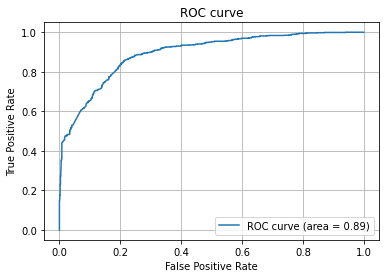

In [42]:
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_valid_xgb, y_vpred)
auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' % auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [53]:
thre_index = list((tpr-fpr)).index(max(tpr-fpr))
thre_index

264

In [54]:
thresholds[thre_index]

0.5037705

In [55]:
y_pred2 = np.where(y_pred >= 0.5037705, 1, 0)
y_pred2 = y_pred2.astype(bool)
output2 = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Transported': y_pred2})
output2.to_csv('output/xgb_submission_ver02_thre0.5037705.csv', index=False)